# Actividad 3: RNN y sus aplicaciones en las series temporales

En esta actividad se va a aplicar el conocimiento adquirido sobre las RNN para entrenar modelos que sean capaces de predecir el comportamiento de las series temporales. Para ello, se usará un dataset de temperaturas para mediante la aplicación de RNN, predecir los valores futuros que tendrá la serie temporal que se tiene. Este trabajo se suele hacer mediante modelos ARIMA, pero en esta práctica se verá cómo el modelado mediante RNN es una opción muy buena en estos casos de series temporales.

**1. Descargar el dataset y almacenarlo**

En primer lugar hay que importar tensorflow.

In [60]:
import tensorflow as tf
print(tf.__version__)

2.16.1


El siguiente paso es importar las bibliotecas numpy y matplotlib. Además, se define el método **plot_series** que se utilizará para hacer las gráficas de las series temporales.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

A continuación se descarga el dataset de las temperaturas mínimas diarias.

In [62]:
import requests
import os

# URL del dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

# Obtenemos el directorio de trabajo actual para guardar el archivo ahí
current_dir = os.getcwd()
file_path = os.path.join(current_dir, "daily-min-temperatures.csv")

# Hacemos la solicitud HTTP para obtener el contenido del archivo
response = requests.get(url)

# Guardamos el contenido en un archivo en el directorio de trabajo actual
with open(file_path, 'wb') as file:
    file.write(response.content)

print(f"Archivo descargado correctamente en {file_path}")


Archivo descargado correctamente en c:\Users\migue\OneDrive\Documentos\Master_UNIR\Especialista Universitario en Big Data e IA\Sistemas Cognitivos Artificiales\Actividades\Act3\daily-min-temperatures.csv


En este paso, se utilizará la biblioteca csv de Python para guardar y poder leer el dataset de temperaturas mínimas diarias que ha sido descargado en el paso anterior. Además, se construye la variable **series** que será donde se guarde la serie temporal. Por último, siempre que se trate con una serie temporal, es una buena práctica hacer un gráfico para poder verla y tener una idea de cómo es.

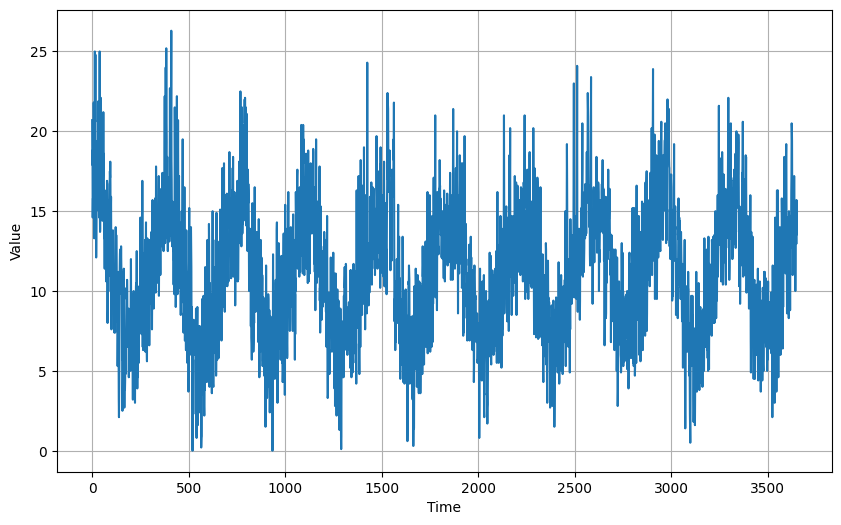

In [63]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# 2. Creación de las variables necesarias para el diseño de la red neuronal

Una técnica muy común cuando se trata con series temporales es utilizar una ventana temporal que se vaya desplazando sobre la serie temporal para reducir su análisis a lo que ocurre en ese ventana de forma local, para a continuación realizar el modelado global.

**Ejercicio 1 (0.4 puntos)**: Crear las variables de entrenamiento y validación y hacer la partición de las mismas. Las variables que hay que crear son:

*   time_train
*   x_train
*   time_valid
*   x_valid





En primer lugar, dividimos la serie temporal en conjuntos de entrenamiento y validación utilizando el índice 'split_time'.

Después, definimos las funciones que generan lotes de datos con una ventana deslizante que avanza sobre la serie temporal para el entrenamiento.

In [64]:
## variables para la técnica de la ventana temporal
split_time = 2500 # Índice para dividir datos en entrenamiento y test
window_size = 30 # Cantidad de pasos temporales en cada ventana
batch_size = 32 # Tamaño de cada lote de datos
shuffle_buffer_size = 1000 # Tamaño del buffer para mezclar datos

## Split del dataset en entrenamiento y validación
time_train = time[:split_time] # Tiempos de entrenamiento
x_train = series[:split_time] # Datos de entrenamiento
time_valid = time[split_time:] # Tiempos de validación
x_valid = series[split_time:] # Datos de validación

2. Creación del método **windowed_dataset** para poder utilizarlo en el modelo. Las entradas por parámetros del método son:

*   series
*   window_size
*   batch_size
*   shuffle_buffer

El resto de elementos que se usan para construir la función ventana temporal para explorar el dataset, son métodos de Python para tratar con series temporales.




<Figure size 1000x600 with 0 Axes>

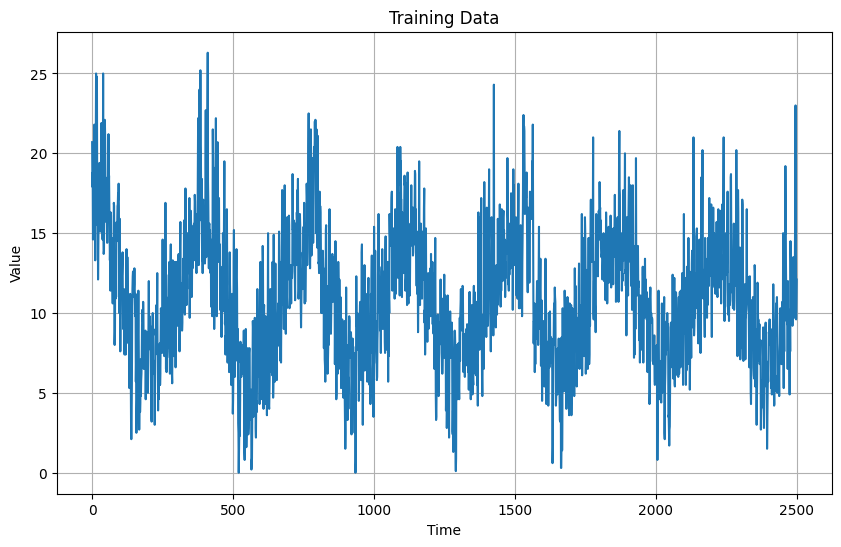

<Figure size 1000x600 with 0 Axes>

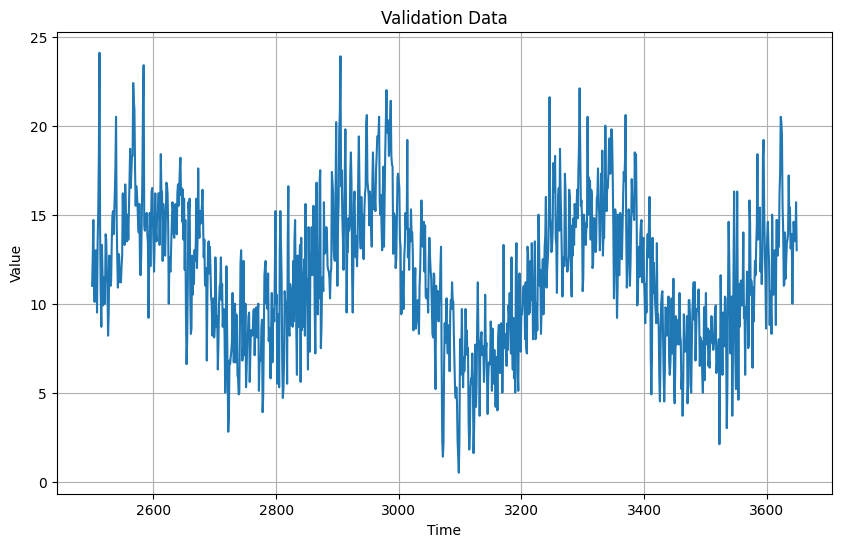

In [65]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Prepara un dataset TensorFlow usando una ventana deslizante que agrupa los datos en 
    formatos consecutivos para el entrenamiento de modelos de series temporales.
    
    Args:
    series (array-like): Datos de la serie temporal.
    window_size (int): Cantidad de pasos temporales por ventana.
    batch_size (int): Tamaño de lote para el entrenamiento.
    shuffle_buffer (int): Tamaño del buffer de mezcla para aleatorizar los elementos.
    
    Returns:
    tf.data.Dataset: Dataset configurado para el entrenamiento del modelo.
    """    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Creamos los datasets de ventana temporal para entrenamiento y validación
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Función para visualizar una parte de los datos
def plot_series(time, series, format="-", start=0, end=None):
    """
    Grafica los datos de la serie temporal.
    
    Args:
    time (array-like): Vector de tiempos asociados a los datos de la serie.
    series (array-like): Datos de la serie temporal a graficar.
    format (str): Estilo del trazo de la línea en la gráfica.
    start (int): Índice inicial de los datos a graficar.
    end (int): Índice final de los datos a graficar.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title('Training Data')
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title('Validation Data')

plt.show()

# 3. Diseño de la función para predecir los siguientes valores de la serie temporal usando la técnica de la ventana temporal

In [66]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

A continuación, y usando como modelo el método **windowed_dataset** se procederá a adaptar el método **model_forecast** que se usará para predecir los siguientes valores de la serie temporal utilizando la técnica de la ventana temporal.

**Ejercicio 2 (1.6 puntos)**: completar el método model_forecast creando los elementos necesarios dentro del método:

1.   Crear la variable **ds** y darle el valor resultante del método **from_tensor_slices** pasando por parametro **series** **(0.4 puntos)**
2.   Actualizar la ventana (**window**) de la variable **ds** (nota: en este caso el tamaño es el mismo de la ventana, no es necesario que sea window_size+1) **(0.4 puntos)**
3.   Crear el **flat_map** de la variable, teniendo en cuenta que el tamaño es **window_size** **(0.4 puntos)**
4.   Añadir la siguiente linea de código: ds = ds.batch(32).prefetch(1)
5.   Crear la variable **forecast** en la que se usará el método **predict** **(0.4 puntos)**
6.   Por último, se devolverá la variable forecast.




In [67]:
def model_forecast(model, series, window_size):
    """
    Esta función prepara un conjunto de datos en una forma que un modelo de predicción (como un modelo RNN) puede consumir fácilmente
    para realizar predicciones basadas en la técnica de ventana temporal.
    
    Args:
    model (tf.keras.Model): Modelo entrenado para hacer predicciones.
    series (array-like): Datos de la serie temporal.
    window_size (int): Tamaño de la ventana de datos utilizada para generar cada muestra.
    
    Returns:
    array-like: Predicciones del modelo para la serie temporal proporcionada.
    """

    # 1. Creamos la variable 'ds' y la asignamos el valor de salida del método 'from_tensor_slices' pasando por parámetro 'series'
    ds = tf.data.Dataset.from_tensor_slices(series)

    # 2. Actualizamos la ventana de la variable 'ds'
    ds = ds.window(window_size, shift=1, drop_remainder=True)

    # 3. Creamos el flat_amp de la variable, teniendo en cuenta que el tamaño es window_size
    ds = ds.flat_map(lambda window: window.batch(window_size))

    # 4. Añadimos la línea de código para preparar el dataset par ael batch y la predicción
    ds = ds.batch(32).prefetch(1)

    # 5. Crear la variable forecast en la que se usará el método predict
    forecast = model.predict(ds)

    # 6. Devolvemos la variable
    return forecast


A continuación, se limpia la sesión de keras, y se inicializan las variables necesarias para poder diseñar el modelo de series temporales a entrenar usando RNN.

Añadimos también la definición del valor de 'shuffle_buffer_size' en la configuración de los parámetros para aumentar la efectividad del entrenamiento y la generalización del modelo.

In [68]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

# 4. Diseño de la red neuronal

**Ejercicio 3.1 (0.5 puntos)**: Hay que crear la variable **train_set** dandole el valor que se reciba del método **windowed_datset**, los parametros que debe recibir este método son: **x_train, window_size, batch_size, shuffle_buffer_size**

In [69]:
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**Ejercicio 3.2 (4 puntos)**: Se debe construir la red neuronal de aprendizaje profunda basada para modelar la serie temporal de las temperaturas minimas diarias. Esta red neuronal debera contar con las siguientes capas ocultas:

1.   Una capa de convolución en una dimensión que tenga 32 filtros, una tamaño del kernel de 5, un stride de 1, padding "causal", la función de activación debe ser relu y el input shape debe ser [None, 1] 
2.   Una capa LSTM con 64 neuronas y retorno de secuencias 
3.   Una capa LSTM con 64 neuronas y retorno de secuencias 
4.   Una capa densa con 30 neuronas
5.   Una capa densa con 10 neuronas
6.   Una capa densa con 1 neuronas
7.   Por último, se añade la siguiente capa: tf.keras.layers.Lambda(lambda x: x * 400)




In [70]:
"""Esta red combina convolución en una dimensión y capas LSTM, seguidas de varias capas densas, y termina con una capa Lambda para ajustar la escala de la salida."""
model = tf.keras.models.Sequential([
    # Capa de convolución en 1D
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                            strides=1, padding="causal",
                            activation="relu",
                            input_shape=[None, 1]),
    # Primera capa LSTM
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Segunda capa LSTM
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Capa densa con 30 neuronas
    tf.keras.layers.Dense(30, activation="relu"),
    # Capa densa con 10 neuronas
    tf.keras.layers.Dense(10, activation="relu"),
    # Capa densa con 1 neurona
    tf.keras.layers.Dense(1),
    # Capa Lambda para escalar la salida
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Compilación del modelo
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(), metrics=["mae"])

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 30)       │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 10)       │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 1)        │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,319 (235.62 KB)

 Trainable params: 60,319 (235.62 KB)

 Non-trainable params: 0 (0.00 B)

### Explicación de la configuración del modelo:
#### Capa Conv1D
Esta capa usa 32 filtros con un tamaño de kernel de 5.
#### Capas LSTM
Se utilizan dos capas LSTM con 64 unidades cada una. 'return_sequences=True' en ambas capas permite que la salida de cada tiempo sea pasada a la siguiente capa, algo importante cuando se apilan capas LSTM.
#### Capas Densas
Las capas densas son parte de la red "feed-forward" que sigue a las LSTM. Aquí, usamos dos con 30 y 10 neuronas respectivamente, ambas con activación ReLU, seguido de una capa densa con una sola neurona sin función de activación para la predicción final.
#### Capa Lambda
Esta capa final multiplica la salida por 400.

# 5. Entrenamiento de la red neuronal

**Ejercicio 4 (0.5 puntos)**: Se va a diseñar un método callbacks para el learning rate que será guardado en la variable **lr_schedule**, este método deberá usar el método **LearningRateScheduler** de Python y será una función **lambda** que le de el valor a epoch de 1e-8 * 10**(epoch / 20) **texto en negrita** 

In [71]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

**Ejercicio 5 (1.5 puntos):** Compilar la red neuronal con los siguientes parametros:

*   loss: método Huber de keras
*   El optimizador debe ser el SGD con learning rate 1e-8 y momentum 0.9
*   La métrica a visualizar es el error absoluto medio (medium absolute error en ingles)



In [72]:
# Configuramos el modelo
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal",
                            activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),  # Corregido aquí
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Compilamos
model.compile(
    loss=tf.keras.losses.Huber(),  # Función de pérdida de Huber
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),  # Optimizador SGD
    metrics=["mae"]  # Métrica de error absoluto medio
)

# Resumen del modelo para confirmar la configuración
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, None, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, None, 30)       │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, None, 10)       │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 1)        │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, None, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,319 (235.62 KB)

 Trainable params: 60,319 (235.62 KB)

 Non-trainable params: 0 (0.00 B)

Para terminar se entrena el modelo previamente diseñado y compilado en los pasos anteriores.

In [73]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 39.9294 - mae: 40.4285 - learning_rate: 1.0000e-08
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 37.7611 - mae: 38.2601 - learning_rate: 1.1220e-08
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 34.2635 - mae: 34.7625 - learning_rate: 1.2589e-08
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 29.9043 - mae: 30.4033 - learning_rate: 1.4125e-08
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 24.8697 - mae: 25.3687 - learning_rate: 1.5849e-08
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 19.5011 - mae: 19.9997 - learning_rate: 1.7783e-08
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 14.3069 - mae: 14.8008 - learning_rate: 1.9953e-08
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 11.1794 - mae: 11.6710 - learning_rate: 2.2387e-08
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 10.0975 - mae: 10.5911 - learning_rate: 2.5119e-08
E

# 6. Actualización del learning rate según los resultados obtenidos del primer entrenamiento de la red neuronal

Después del entrenamiento de la red neuronal se ve que learning rate resultante es de 1e-5. Se visualizará gráficamente para entender el motivo por el que se ha usado ese valor. En la gráfica se puede ver cómo el learning rate con el que menos loss hay es 1e-5, y por ese motivo, se debe volver a entrenar la red neuronal con dicho learning rate.

(1e-08, 0.0001, 0.0, 50.0)

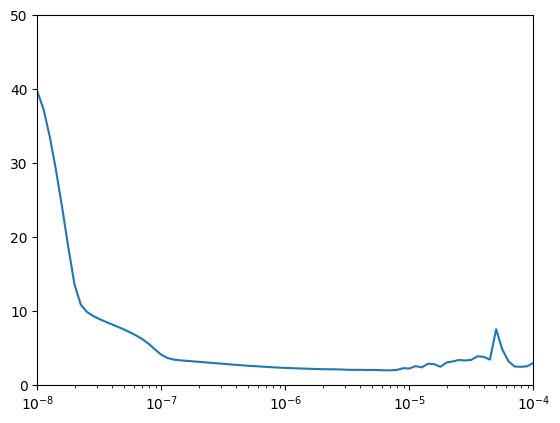

In [76]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 50])

Se vuelve a inicializar la sesión de entrenamiento y la variable train_set:

In [77]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

**Ejercicio 6 (0.5 puntos)**: Para crear el nuevo modelo, reutiliza la red neuronal diseñada en el ejercicio 4, pero esta vez utilizando 60 filtros en la capa de convolución.

In [78]:
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

# Configuración del modelo con 60 filtros en la capa de convolución
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal",
                            activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

c:\Anaconda\envs\Sist_Cognitivos_Artificiales\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Ejercicio 7 (0.5 puntos)**: Se debe volver a compilar la red neuronal de manera análoga a la del ejercicio 5, pero esta vez utilizar un learning rate obtenido de la función callback.

In [79]:
# Suponiendo que el learning rate óptimo encontrado es 1e-5
optimal_learning_rate = 1e-5

# Compilación de la red neuronal con el learning rate obtenido
model.compile(
    loss=tf.keras.losses.Huber(),  # Uso de la función de pérdida de Huber
    optimizer=tf.keras.optimizers.SGD(learning_rate=optimal_learning_rate, momentum=0.9),  # Optimizador SGD con el learning rate óptimo
    metrics=["mae"]  # Métrica de error absoluto medio
)

# Resumen del modelo para confirmar la configuración
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, None, 60)       │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 64)       │        32,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 30)       │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 10)       │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 1)        │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, None, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,655 (264.28 KB)

 Trainable params: 67,655 (264.28 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 11.2141 - mae: 11.7043
Epoch 2/150
 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 5.3948 - mae: 5.8846

c:\Anaconda\envs\Sist_Cognitivos_Artificiales\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 5.2472 - mae: 5.7349
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.0819 - mae: 4.5621
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.8240 - mae: 4.3030
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.3312 - mae: 3.8070
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 3.0216 - mae: 3.4950
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.6062 - mae: 3.0741
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 2.4253 - mae: 2.8897
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.8539 - mae: 2.3060
Epoch 10/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.7693 - mae: 2.2186
Epoch 11/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.7224 - mae: 2.1708
Epoch 12/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.7113 - mae: 2.1588
Epoch 13/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.6914 - mae: 2.1382
Epoch 14/150
25/25 ━━━━━━━━━━━━━━━━━

# 7. Predicción de los siguientes valores de la serie temporal

Para concluir la actividad, se usa el método model_forecast que se ha diseñado utilizando el método de la ventana temporal para hacer el nuevo metodo rnn_forecast con el cual se calcularán los nuevos valores de la serie temporal. Posteriormente, se pinta una gráfica para ver esos resultados y comprobar de forma visual que son correctos. Además, se dan los resultados de esas predicciones en forma númerica, de esta forma, este modelo diseñado en esta actividad podría ser el input de un nuevo algoritmo si fuera necesario.

In [81]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


<Figure size 1000x600 with 0 Axes>

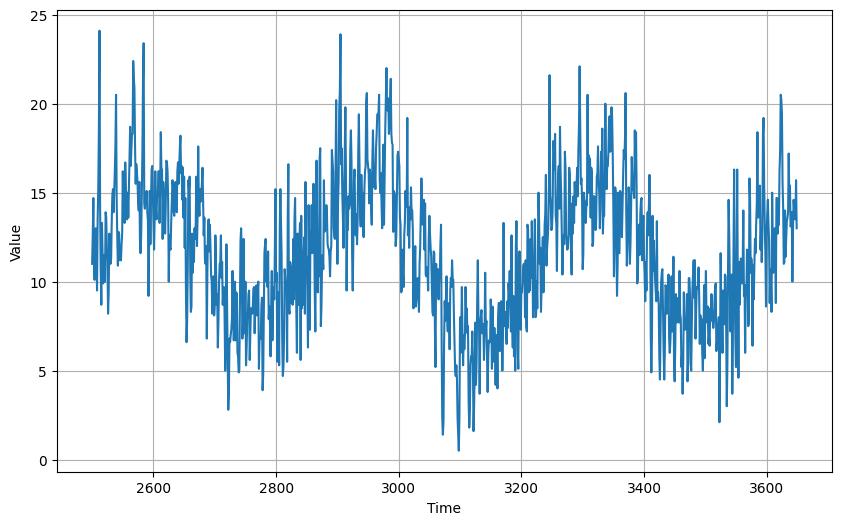

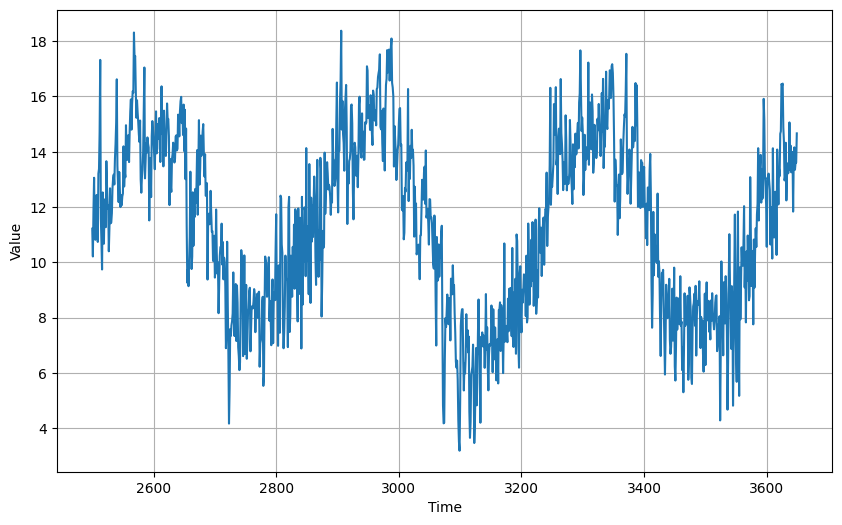

In [82]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [91]:
# Inicializamos la métrica
mae_metric = tf.keras.metrics.MeanAbsoluteError()

# Calculamos el MAE
mae_metric.update_state(x_valid, rnn_forecast)
mae_value = mae_metric.result().numpy()  # Obtenemos el valor

print("Mean Absolute Error:", mae_value)


Mean Absolute Error: 1.8105675


In [92]:
print(rnn_forecast)

[11.218924 10.214475 11.901641 ... 13.611639 13.608533 14.664597]


# 8. Mostrar gráficamente los resultados.

Una vez obtenido el resultado de la actividad, se procede a revisr de forma gráfica el training y validation loss a lo largo de los epochs en este nuevo entrenamiento con el learning rate optimizado.

In [93]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recuperar una lista de resultados de la lista de datos de entrenamiento y pruebas para cada epoch de entrenamiento
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

A continuación se realiza el plot de la pérdida frente a los epochs

<Figure size 640x480 with 0 Axes>

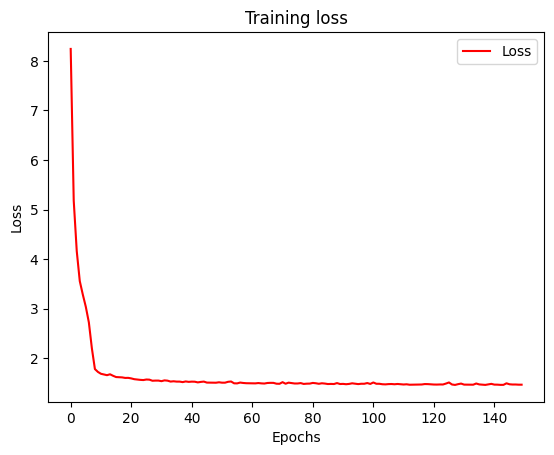

<Figure size 640x480 with 0 Axes>

In [94]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

**Ejercicio 8 (0.5 punto)**: Utilizando las 2 nuevas variables zoomed_loss y zoomed_epochs y con base en el código anterior, hacer el plot del loss frente a los epochs entre los epoch 20 y 150 para ver como va oscilando y no es un proceso lineal como podria parecer según el anterior plot.

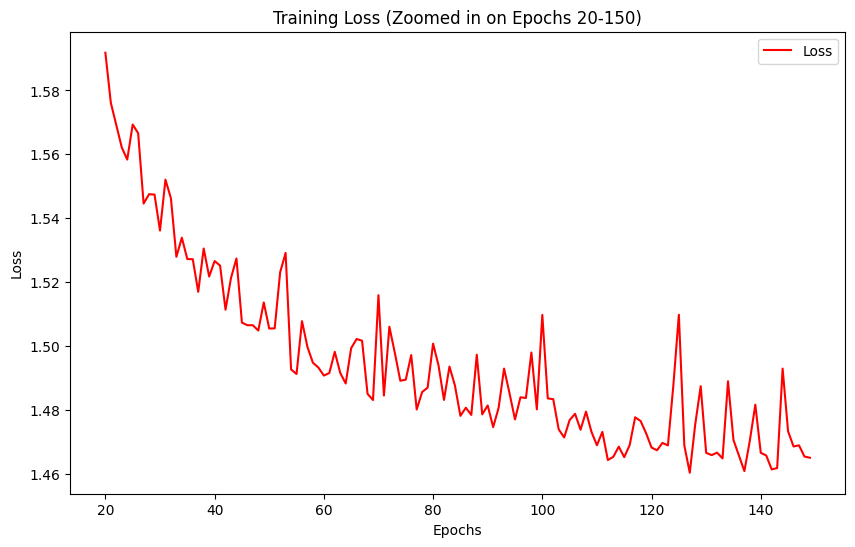

In [95]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch con zoom
#------------------------------------------------
zoomed_loss = loss[20:]
zoomed_epochs = range(20,150)

# Graficamos la pérdida de entrenamiento con zoom
plt.figure(figsize=(10, 6))
plt.plot(zoomed_epochs, zoomed_loss, 'r') 
plt.title('Training Loss (Zoomed in on Epochs 20-150)')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.show()

El gráfico obtenido representa el comportamiento de la función de pérdida en un segmento específico del entrenamiento.
Es de utilidad para identificar sobreajustes, posibles ajustes de hiperparámetros o para comprender la dinámica del aprendizaje del modelo por epochs.